<a href="https://colab.research.google.com/github/Svatunek-Lab/teaching/blob/main/2025_University_of_Malaya_Intro_Chemistry_Python/RDkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chemistry in Python

In this section, we explore how chemistry can be represented and analyzed directly in Python using **RDKit**, a popular open-source cheminformatics toolkit.  

We will learn how to:
- **Represent molecules** using text-based notations such as **SMILES**, which uniquely describe chemical structures.  
- **Visualize molecules** in both **2D** (for structural formulas) and **3D** (for spatial geometry and conformers).  
- **Calculate molecular descriptors**, such as molecular weight, logP, or polar surface area, which quantify chemical and physical properties.  
- **Convert molecules into data**, preparing them for further analysis or **machine learning** workflows.  

By the end of this section, you will understand how to represent and analyze molecules directly in Python.


## Setup and Preparation

Before we begin, we need to install a few essential packages:  
**RDKit** for chemical structure handling and basic computations,  
and **py3Dmol** for interactive 3D visualization of molecules.  

Once these are installed, we are ready to start exploring and visualizing real molecular structures in Python.



In [2]:
!pip install -q rdkit py3Dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 39.2 MB/s eta 0:00:00


## Molecules as Python Objects

In RDKit, molecules are represented by **`Mol` objects**.  
These objects store all information about the molecule — atoms, bonds, and connectivity — in a form that Python can access and manipulate.

A `Mol` object can be created from a **SMILES** string, which encodes the structure as plain text.  
Once created, we can inspect its properties or visualize it directly.

In the next example, we will:
1. Create a molecule from its SMILES representation.  
2. Check how many atoms and bonds it contains.  
3. Display its 2D structure.


In [21]:
from rdkit import Chem

# create mol object from SMILES
mol = Chem.MolFromSmiles("O=C(OC1CC=CCC1)C")


In [22]:
print(type(mol))

<class 'rdkit.Chem.rdchem.Mol'>


In [23]:
print(mol.GetNumAtoms(), "atoms")
print(mol.GetNumBonds(), "bonds")

10 atoms
10 bonds


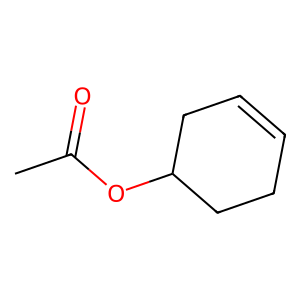

In [20]:
from rdkit.Chem import Draw
Draw.MolToImage(mol)

## Substructure search (SMARTS) and highlighting

A powerful feature of RDKit is **substructure search**: finding a pattern (functional group, ring, motif) inside a molecule.

- Patterns are written as **SMARTS** (like regex for molecules).
- Create a query with `Chem.MolFromSmarts(...)`.
- Find all occurrences with `mol.GetSubstructMatches(query)`.
- Highlight the matched atoms/bonds when drawing.

Below, we search for a **carbonyl group** and highlight every match.


Matches found: 1
((3, 4),)


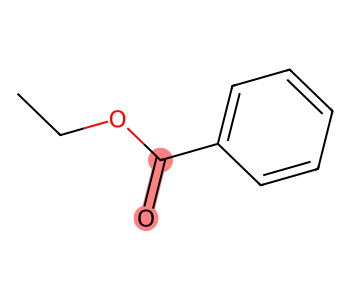

In [24]:
from rdkit import Chem
from rdkit.Chem import Draw

# Example molecule (ethyl benzoate)
mol = Chem.MolFromSmiles("CCOC(=O)c1ccccc1")

# SMARTS for a generic carbonyl C=O (sp2 carbonyl carbon)
query = Chem.MolFromSmarts("[CX3]=[OX1]")

matches = mol.GetSubstructMatches(query)  # tuple of atom-index tuples
print(f"Matches found: {len(matches)}")
print(matches)

# Collect atom and bond indices to highlight
highlight_atoms = set(a for m in matches for a in m)
highlight_bonds = []
for m in matches:
    # map query bonds to target bonds to highlight them too
    for qb in query.GetBonds():
        a1 = m[qb.GetBeginAtomIdx()]
        a2 = m[qb.GetEndAtomIdx()]
        b = mol.GetBondBetweenAtoms(a1, a2)
        if b is not None:
            highlight_bonds.append(b.GetIdx())

img = Draw.MolToImage(
    mol,
    size=(350, 300),
    kekulize=True,
    highlightAtoms=list(highlight_atoms),
    highlightBonds=highlight_bonds,
)
img


### Searching a list of molecules

We can filter a small “library” to those that **contain** a motif and show them side-by-side.


Molecules containing a carbonyl: 4 / 5


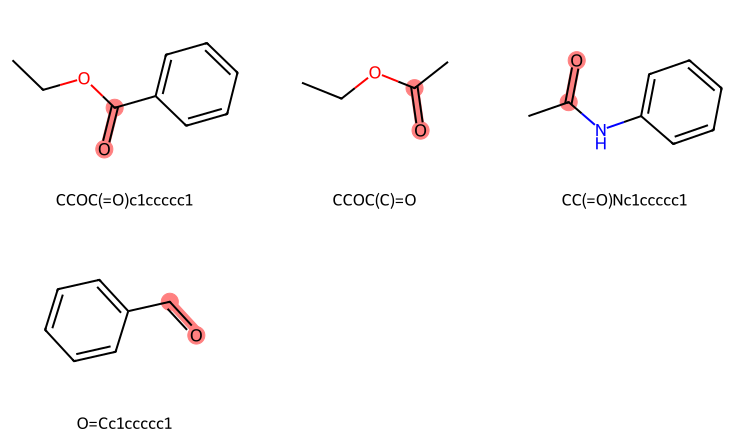

In [25]:
from rdkit.Chem import Draw

smis = [
    "CCOC(=O)c1ccccc1",   # ethyl benzoate
    "CC(=O)OCC",          # ethyl acetate
    "CCO",                # ethanol (no carbonyl)
    "O=C(Nc1ccccc1)C",    # acetanilide
    "c1ccccc1C=O",        # benzaldehyde
]

mols = [Chem.MolFromSmiles(s) for s in smis]
query = Chem.MolFromSmarts("[CX3]=[OX1]")  # carbonyl

hits = []
highlight_atom_lists = []
highlight_bond_lists = []

for m in mols:
    ms = m.GetSubstructMatches(query)
    if not ms:
        continue
    hits.append(m)
    # prepare highlights for each molecule (grid accepts list-of-lists)
    ha = set(a for match in ms for a in match)
    hb = []
    for match in ms:
        for qb in query.GetBonds():
            a1 = match[qb.GetBeginAtomIdx()]
            a2 = match[qb.GetEndAtomIdx()]
            b = m.GetBondBetweenAtoms(a1, a2)
            if b is not None:
                hb.append(b.GetIdx())
    highlight_atom_lists.append(list(ha))
    highlight_bond_lists.append(hb)

print(f"Molecules containing a carbonyl: {len(hits)} / {len(mols)}")

grid = Draw.MolsToGridImage(
    hits,
    molsPerRow=3,
    subImgSize=(250, 220),
    legends=[Chem.MolToSmiles(m) for m in hits],
    highlightAtomLists=highlight_atom_lists,
    highlightBondLists=highlight_bond_lists,
    useSVG=False,
)
grid


## From 2D (SMILES) to 3D (conformer)

Goal: start from a SMILES string, generate a **3D conformer**, perform a quick **geometry optimization**, and **view** it interactively.

Steps:
1) Create `Mol` from SMILES and **add hydrogens** (needed for sensible 3D).  
2) **Embed** a 3D conformer using ETKDG (knowledge-based distances).  
3) **Optimize** with a simple force field (UFF or MMFF).  
4) Visualize with **py3Dmol**.

Notes:
- ETKDG gives good initial geometries.  
- Use **MMFF** if parameters are available; fall back to **UFF** otherwise.  
- You can generate **multiple conformers** to sample geometry.


In [31]:
from rdkit import Chem
from rdkit.Chem import AllChem

# 1) Start from SMILES (ethyl benzoate here)
smiles = "CCOC(=O)c1ccccc1"
mol2d = Chem.MolFromSmiles(smiles)

# 2) Add hydrogens and embed a 3D conformer
mol3d = Chem.AddHs(mol2d)
AllChem.EmbedMolecule(mol3d, AllChem.ETKDG())  # ETKDG embedding

# 3) Optimize geometry with MMFF
AllChem.MMFFOptimizeMolecule(mol3d)




0

In [32]:
# 4) show 3D coordinates

conf = mol3d.GetConformer()

for atom in mol3d.GetAtoms():
    pos = conf.GetAtomPosition(atom.GetIdx())
    print(f"{atom.GetSymbol():<2} {pos.x:12.6f} {pos.y:12.6f} {pos.z:12.6f}")


C      3.510615     0.238128     0.451524
C      2.549112    -0.735692     1.106383
O      1.195847    -0.296215     0.918703
C      0.599771    -0.697749    -0.231915
O      1.111601    -1.383382    -1.102883
C     -0.794643    -0.181958    -0.307095
C     -1.361202     0.608283     0.702766
C     -2.675519     1.066608     0.581070
C     -3.428980     0.739608    -0.545943
C     -2.872572    -0.045683    -1.554539
C     -1.559431    -0.505629    -1.436619
H      3.349805     0.281588    -0.630304
H      4.547363    -0.055235     0.638935
H      3.354422     1.250783     0.837628
H      2.729895    -0.761446     2.185980
H      2.693279    -1.755621     0.731708
H     -0.792118     0.875406     1.589607
H     -3.111495     1.679345     1.366468
H     -4.451647     1.097497    -0.638421
H     -3.459903    -0.300585    -2.433299
H     -1.134200    -1.118050    -2.229753


In [34]:
# 5) Visualize in 3D
import py3Dmol
mb = Chem.MolToMolBlock(mol3d)
view = py3Dmol.view(width=400, height=350)
view.addModel(mb, "mol")
view.setStyle({"stick": {"radius": 0.15}, "sphere": {"scale": 0.25}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Calculating Molecular Properties

RDKit can calculate many **molecular descriptors** — numerical properties derived from structure.  
These include:
- **Physicochemical properties** (e.g., molecular weight, logP, polar surface area)
- **Structure counts** (e.g., number of rings, rotatable bonds, hydrogen bond donors/acceptors)
- **Topological indices** (e.g., molecular complexity, connectivity descriptors)

Descriptors are useful for:
- Comparing molecules  
- Creating datasets for **machine learning**  
- Screening and filtering chemical libraries
